In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [2]:
# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        
        # Get image paths for real and fake images
        self.real_images = os.listdir(real_dir)
        self.fake_images = os.listdir(fake_dir)
        
        # Create full paths for the images and assign labels
        self.image_paths = [os.path.join(real_dir, img) for img in self.real_images] + \
                           [os.path.join(fake_dir, img) for img in self.fake_images]
        
        # 0 for real, 1 for fake
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
from torchvision import transforms

# Enhanced Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes images to 224x224
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.RandomRotation(15),  # Rotate images by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Change brightness, contrast, etc.
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Small affine transformations (rotation, translation, etc.)
    transforms.RandomCrop(224, padding=10),  # Random crop with padding for more variance
    transforms.ToTensor(),  # Converts image to tensor, scales pixel values to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats THIS IS KEY HERE AS WE ARE USING A PRETRAINED MODEL
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
from sklearn.model_selection import train_test_split

# Define paths to your real and fake image directories
real_dir = 'final_cleaned_dataset/resized_data/rezised_real'
fake_dir = 'final_cleaned_dataset/resized_data/rezised_fake'

# Create the full dataset
full_dataset = ImageDataset(real_dir, fake_dir, transform=train_transform)

# Split the dataset into training (75%), validation (15%), and testing (15%)
train_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42, stratify=full_dataset.labels)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42, stratify=[full_dataset.labels[i] for i in test_indices])

# Create Subsets for train/val/test
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

# Load the pretrained ViT model for binary classification
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True)

# Move the model to the GPU if available (MPS for Mac M1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [6]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer so it can be trained
for param in model.classifier.parameters():
    param.requires_grad = True

In [7]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [8]:
def train_model(
    model,            # The PyTorch model to train
    train_loader,     # DataLoader for training data
    val_loader,       # DataLoader for validation data
    device,           # Device (cpu, mps, or cuda)
    num_epochs=10,    # Number of epochs to train for
    lr=1e-4,          # Learning rate
    model_save_path='best_model.pth'  # Path to save the best model
):
    # Define the optimizer and loss function
    optimizer = optim.AdamW(model.classifier.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for binary classification

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_recall = 0.0  # To track the model with the best recall

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with tqdm progress bar
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the epoch
        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images).logits
                loss = loss_fn(val_outputs, val_labels)

                # Track validation loss and accuracy
                val_loss += loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_samples += val_labels.size(0)

                # Collect labels and predictions for metrics calculation
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(val_predicted.cpu().numpy())

        # Calculate average validation loss and accuracy
        epoch_val_loss = val_loss / val_total_samples
        epoch_val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Calculate precision, recall, f1, and support using sklearn
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
        print(f'Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1-Score: {f1:.4f}')

        # Save the model if it has the best recall
        if recall > best_val_recall:
            best_val_recall = recall
            torch.save(model.state_dict(), model_save_path)
            print(f'Saved best model with validation recall: {best_val_recall:.4f}')

    # Visualize loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load the best model before returning
    model.load_state_dict(torch.load(model_save_path))
    return model

Epoch 1/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  2.96it/s]


Epoch [1/50]
Train Loss: 0.6855, Train Accuracy: 0.6175
Val Loss: 0.6764, Val Accuracy: 0.6857
Val Precision: 0.6691, Val Recall: 0.7349, Val F1-Score: 0.7004
Saved best model with validation recall: 0.7349


Epoch 2/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  2.98it/s]


Epoch [2/50]
Train Loss: 0.6714, Train Accuracy: 0.6648
Val Loss: 0.6615, Val Accuracy: 0.6891
Val Precision: 0.7178, Val Recall: 0.6231, Val F1-Score: 0.6671


Epoch 3/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Epoch [3/50]
Train Loss: 0.6614, Train Accuracy: 0.6589
Val Loss: 0.6554, Val Accuracy: 0.6763
Val Precision: 0.6675, Val Recall: 0.7026, Val F1-Score: 0.6846


Epoch 4/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Epoch [4/50]
Train Loss: 0.6504, Train Accuracy: 0.6731
Val Loss: 0.6407, Val Accuracy: 0.7012
Val Precision: 0.7018, Val Recall: 0.6999, Val F1-Score: 0.7008


Epoch 5/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch [5/50]
Train Loss: 0.6418, Train Accuracy: 0.6781
Val Loss: 0.6341, Val Accuracy: 0.6878
Val Precision: 0.6914, Val Recall: 0.6783, Val F1-Score: 0.6848


Epoch 6/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch [6/50]
Train Loss: 0.6320, Train Accuracy: 0.6856
Val Loss: 0.6284, Val Accuracy: 0.6938
Val Precision: 0.7118, Val Recall: 0.6514, Val F1-Score: 0.6803


Epoch 7/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Epoch [7/50]
Train Loss: 0.6257, Train Accuracy: 0.6917
Val Loss: 0.6194, Val Accuracy: 0.7026
Val Precision: 0.6962, Val Recall: 0.7187, Val F1-Score: 0.7073


Epoch 8/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch [8/50]
Train Loss: 0.6192, Train Accuracy: 0.6954
Val Loss: 0.6145, Val Accuracy: 0.7113
Val Precision: 0.7145, Val Recall: 0.7039, Val F1-Score: 0.7092


Epoch 9/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Epoch [9/50]
Train Loss: 0.6144, Train Accuracy: 0.6938
Val Loss: 0.6056, Val Accuracy: 0.7140
Val Precision: 0.7154, Val Recall: 0.7106, Val F1-Score: 0.7130


Epoch 10/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Epoch [10/50]
Train Loss: 0.6072, Train Accuracy: 0.7095
Val Loss: 0.6044, Val Accuracy: 0.7153
Val Precision: 0.7122, Val Recall: 0.7227, Val F1-Score: 0.7174


Epoch 11/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Epoch [11/50]
Train Loss: 0.6035, Train Accuracy: 0.7107
Val Loss: 0.6019, Val Accuracy: 0.7133
Val Precision: 0.7077, Val Recall: 0.7268, Val F1-Score: 0.7171


Epoch 12/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Epoch [12/50]
Train Loss: 0.5950, Train Accuracy: 0.7201
Val Loss: 0.5946, Val Accuracy: 0.7288
Val Precision: 0.7196, Val Recall: 0.7497, Val F1-Score: 0.7343
Saved best model with validation recall: 0.7497


Epoch 13/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Epoch [13/50]
Train Loss: 0.5945, Train Accuracy: 0.7121
Val Loss: 0.5857, Val Accuracy: 0.7315
Val Precision: 0.7402, Val Recall: 0.7133, Val F1-Score: 0.7265


Epoch 14/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Epoch [14/50]
Train Loss: 0.5888, Train Accuracy: 0.7163
Val Loss: 0.5804, Val Accuracy: 0.7376
Val Precision: 0.7448, Val Recall: 0.7227, Val F1-Score: 0.7336


Epoch 15/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch [15/50]
Train Loss: 0.5809, Train Accuracy: 0.7293
Val Loss: 0.5732, Val Accuracy: 0.7550
Val Precision: 0.7599, Val Recall: 0.7456, Val F1-Score: 0.7527


Epoch 16/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Epoch [16/50]
Train Loss: 0.5780, Train Accuracy: 0.7329
Val Loss: 0.5717, Val Accuracy: 0.7308
Val Precision: 0.7236, Val Recall: 0.7470, Val F1-Score: 0.7351


Epoch 17/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Epoch [17/50]
Train Loss: 0.5763, Train Accuracy: 0.7282
Val Loss: 0.5688, Val Accuracy: 0.7416
Val Precision: 0.7462, Val Recall: 0.7322, Val F1-Score: 0.7391


Epoch 18/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Epoch [18/50]
Train Loss: 0.5698, Train Accuracy: 0.7375
Val Loss: 0.5623, Val Accuracy: 0.7618
Val Precision: 0.7632, Val Recall: 0.7591, Val F1-Score: 0.7611
Saved best model with validation recall: 0.7591


Epoch 19/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch [19/50]
Train Loss: 0.5664, Train Accuracy: 0.7404
Val Loss: 0.5583, Val Accuracy: 0.7571
Val Precision: 0.7493, Val Recall: 0.7725, Val F1-Score: 0.7608
Saved best model with validation recall: 0.7725


Epoch 20/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch [20/50]
Train Loss: 0.5593, Train Accuracy: 0.7469
Val Loss: 0.5508, Val Accuracy: 0.7712
Val Precision: 0.7764, Val Recall: 0.7618, Val F1-Score: 0.7690


Epoch 21/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Epoch [21/50]
Train Loss: 0.5603, Train Accuracy: 0.7457
Val Loss: 0.5595, Val Accuracy: 0.7396
Val Precision: 0.7392, Val Recall: 0.7402, Val F1-Score: 0.7397


Epoch 22/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  2.97it/s]


Epoch [22/50]
Train Loss: 0.5557, Train Accuracy: 0.7472
Val Loss: 0.5500, Val Accuracy: 0.7591
Val Precision: 0.7655, Val Recall: 0.7470, Val F1-Score: 0.7561


Epoch 23/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Epoch [23/50]
Train Loss: 0.5536, Train Accuracy: 0.7463
Val Loss: 0.5431, Val Accuracy: 0.7793
Val Precision: 0.7734, Val Recall: 0.7900, Val F1-Score: 0.7816
Saved best model with validation recall: 0.7900


Epoch 24/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Epoch [24/50]
Train Loss: 0.5517, Train Accuracy: 0.7463
Val Loss: 0.5433, Val Accuracy: 0.7699
Val Precision: 0.7670, Val Recall: 0.7752, Val F1-Score: 0.7711


Epoch 25/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch [25/50]
Train Loss: 0.5444, Train Accuracy: 0.7564
Val Loss: 0.5483, Val Accuracy: 0.7577
Val Precision: 0.7503, Val Recall: 0.7725, Val F1-Score: 0.7613


Epoch 26/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Epoch [26/50]
Train Loss: 0.5431, Train Accuracy: 0.7544
Val Loss: 0.5360, Val Accuracy: 0.7672
Val Precision: 0.7708, Val Recall: 0.7604, Val F1-Score: 0.7656


Epoch 27/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Epoch [27/50]
Train Loss: 0.5388, Train Accuracy: 0.7641
Val Loss: 0.5308, Val Accuracy: 0.7793
Val Precision: 0.7720, Val Recall: 0.7927, Val F1-Score: 0.7822
Saved best model with validation recall: 0.7927


Epoch 28/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Epoch [28/50]
Train Loss: 0.5396, Train Accuracy: 0.7551
Val Loss: 0.5346, Val Accuracy: 0.7752
Val Precision: 0.7828, Val Recall: 0.7618, Val F1-Score: 0.7722


Epoch 29/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Epoch [29/50]
Train Loss: 0.5334, Train Accuracy: 0.7626
Val Loss: 0.5318, Val Accuracy: 0.7651
Val Precision: 0.7592, Val Recall: 0.7766, Val F1-Score: 0.7678


Epoch 30/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Epoch [30/50]
Train Loss: 0.5293, Train Accuracy: 0.7642
Val Loss: 0.5265, Val Accuracy: 0.7773
Val Precision: 0.7655, Val Recall: 0.7995, Val F1-Score: 0.7821
Saved best model with validation recall: 0.7995


Epoch 31/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Epoch [31/50]
Train Loss: 0.5295, Train Accuracy: 0.7674
Val Loss: 0.5296, Val Accuracy: 0.7678
Val Precision: 0.7618, Val Recall: 0.7793, Val F1-Score: 0.7705


Epoch 32/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.02it/s]


Epoch [32/50]
Train Loss: 0.5296, Train Accuracy: 0.7659
Val Loss: 0.5289, Val Accuracy: 0.7705
Val Precision: 0.7709, Val Recall: 0.7699, Val F1-Score: 0.7704


Epoch 33/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Epoch [33/50]
Train Loss: 0.5194, Train Accuracy: 0.7778
Val Loss: 0.5183, Val Accuracy: 0.7799
Val Precision: 0.7708, Val Recall: 0.7968, Val F1-Score: 0.7836


Epoch 34/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch [34/50]
Train Loss: 0.5221, Train Accuracy: 0.7708
Val Loss: 0.5122, Val Accuracy: 0.7840
Val Precision: 0.7972, Val Recall: 0.7618, Val F1-Score: 0.7791


Epoch 35/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch [35/50]
Train Loss: 0.5230, Train Accuracy: 0.7664
Val Loss: 0.5164, Val Accuracy: 0.7672
Val Precision: 0.7686, Val Recall: 0.7645, Val F1-Score: 0.7665


Epoch 36/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Epoch [36/50]
Train Loss: 0.5155, Train Accuracy: 0.7798
Val Loss: 0.5142, Val Accuracy: 0.7779
Val Precision: 0.7880, Val Recall: 0.7604, Val F1-Score: 0.7740


Epoch 37/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Epoch [37/50]
Train Loss: 0.5187, Train Accuracy: 0.7698
Val Loss: 0.5153, Val Accuracy: 0.7826
Val Precision: 0.7800, Val Recall: 0.7873, Val F1-Score: 0.7837


Epoch 38/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Epoch [38/50]
Train Loss: 0.5154, Train Accuracy: 0.7714
Val Loss: 0.5076, Val Accuracy: 0.7934
Val Precision: 0.7962, Val Recall: 0.7887, Val F1-Score: 0.7924


Epoch 39/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Epoch [39/50]
Train Loss: 0.5132, Train Accuracy: 0.7768
Val Loss: 0.4975, Val Accuracy: 0.7968
Val Precision: 0.7921, Val Recall: 0.8048, Val F1-Score: 0.7984
Saved best model with validation recall: 0.8048


Epoch 40/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Epoch [40/50]
Train Loss: 0.5073, Train Accuracy: 0.7811
Val Loss: 0.5078, Val Accuracy: 0.7759
Val Precision: 0.7801, Val Recall: 0.7685, Val F1-Score: 0.7742


Epoch 41/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Epoch [41/50]
Train Loss: 0.5061, Train Accuracy: 0.7805
Val Loss: 0.4974, Val Accuracy: 0.7961
Val Precision: 0.7941, Val Recall: 0.7995, Val F1-Score: 0.7968


Epoch 42/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch [42/50]
Train Loss: 0.5056, Train Accuracy: 0.7867
Val Loss: 0.4946, Val Accuracy: 0.7988
Val Precision: 0.7976, Val Recall: 0.8008, Val F1-Score: 0.7992


Epoch 43/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Epoch [43/50]
Train Loss: 0.5079, Train Accuracy: 0.7772
Val Loss: 0.4949, Val Accuracy: 0.7961
Val Precision: 0.7997, Val Recall: 0.7900, Val F1-Score: 0.7949


Epoch 44/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.03it/s]


Epoch [44/50]
Train Loss: 0.4974, Train Accuracy: 0.7861
Val Loss: 0.4914, Val Accuracy: 0.7867
Val Precision: 0.7817, Val Recall: 0.7954, Val F1-Score: 0.7885


Epoch 45/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Epoch [45/50]
Train Loss: 0.4966, Train Accuracy: 0.7893
Val Loss: 0.5055, Val Accuracy: 0.7766
Val Precision: 0.7729, Val Recall: 0.7833, Val F1-Score: 0.7781


Epoch 46/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch [46/50]
Train Loss: 0.4989, Train Accuracy: 0.7868
Val Loss: 0.4895, Val Accuracy: 0.7907
Val Precision: 0.7888, Val Recall: 0.7941, Val F1-Score: 0.7914


Epoch 47/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch [47/50]
Train Loss: 0.4974, Train Accuracy: 0.7855
Val Loss: 0.4897, Val Accuracy: 0.8129
Val Precision: 0.8181, Val Recall: 0.8048, Val F1-Score: 0.8114


Epoch 48/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch [48/50]
Train Loss: 0.4941, Train Accuracy: 0.7893
Val Loss: 0.4930, Val Accuracy: 0.7887
Val Precision: 0.7895, Val Recall: 0.7873, Val F1-Score: 0.7884


Epoch 49/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.03it/s]


Epoch [49/50]
Train Loss: 0.4910, Train Accuracy: 0.7922
Val Loss: 0.4877, Val Accuracy: 0.7894
Val Precision: 0.8063, Val Recall: 0.7618, Val F1-Score: 0.7834


Epoch 50/50 [Validation]: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Epoch [50/50]
Train Loss: 0.4930, Train Accuracy: 0.7831
Val Loss: 0.4824, Val Accuracy: 0.8048
Val Precision: 0.7908, Val Recall: 0.8291, Val F1-Score: 0.8095
Saved best model with validation recall: 0.8291


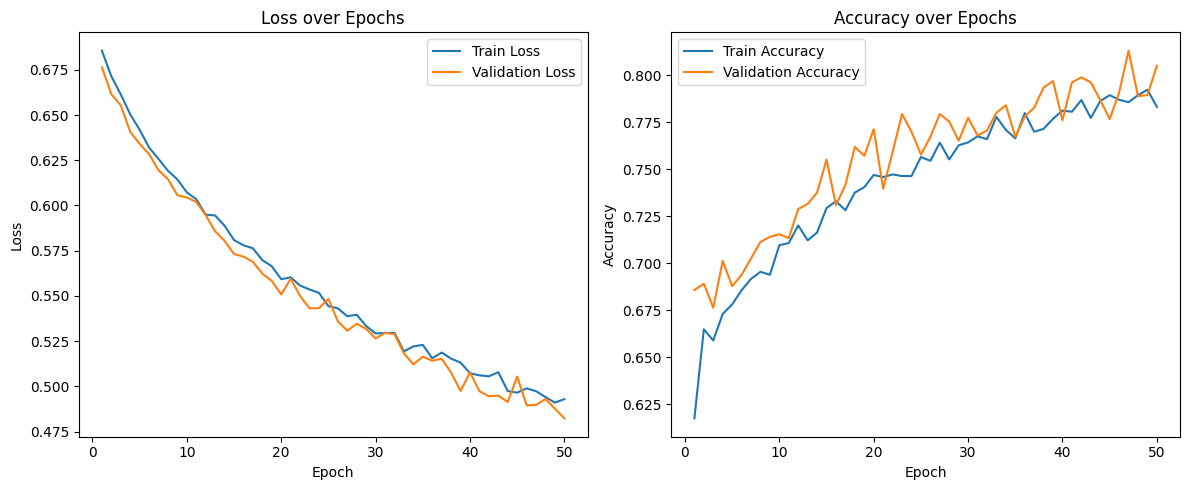

In [9]:
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=50, lr=1e-5, model_save_path='best_vit_model.pth')